In [2]:
import numpy as np
import wandb
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as td
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [6]:

# 形状为 (5000, 3, 96, 96, 1)
data = np.load("large94_2D.npy",allow_pickle=True)
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
print(device)

# 打印新的数据形状
print(data.shape)


cuda
(5000, 3, 96, 96)


In [4]:
class CNNAE(nn.Module):
    def __init__(self):
        super(CNNAE, self).__init__()

        # 编码器
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.PReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.PReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.Flatten()
        )

        self.fc1 = nn.Linear(64*12*12, 1024)  # 这里的输入大小需要根据你的数据和卷积层的设计进行调整
        self.fc2 = nn.Linear(1024, 64*12*12)  # 这里的输出大小需要和fc1的输入大小匹配

        # 解码器
        self.decoder = nn.Sequential(
            nn.PReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.PReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.PReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
        )

    def forward(self, x):
        x = self.encoder(x)
        #print(x.shape)  # print the output shape of the encoder
        x = self.fc1(x)
        x = self.fc2(x)
        x = x.view(x.size(0), 64, 12, 12)
        x = self.decoder(x)
        return x


In [7]:

data_2D = torch.from_numpy(data).float().to(device)
#  (N, C, H, W) 的 numpy 数组
mean = torch.mean(data_2D, dim=(0, 2, 3))  # 沿着每个通道计算平均值
print(mean)

std = torch.std(data_2D, dim=(0, 2, 3))  # 沿着每个通道计算标准差
print(std)



class Normalize3D:
    def __init__(self, mean, std) -> None:
        self.mean = mean.view(1, 3, 1, 1)
        self.std = std.view(1, 3, 1, 1)
    def __call__(self, tensor):
        return (tensor - self.mean) / self.std


normalizer = Normalize3D(mean=mean, std=std)

normalized_data = normalizer(data_2D)


tensor([-0.0094, -0.0011,  0.0126], device='cuda:0')
tensor([0.0989, 0.0964, 0.1371], device='cuda:0')


In [16]:
#加入物理约束
def compute_physical_constraint_loss2(output):
    Hx_x = torch.gradient(output[:, 0], axis=2)[0]
    Hy_y = torch.gradient(output[:, 1], axis=1)[0]

    if output.shape[1] == 3:
        Hz_z = torch.gradient(output[:, 2], axis=2)[0]
        div_mag = torch.stack([Hx_x, Hy_y, Hz_z], dim=1)
    else:
        div_mag = torch.stack([Hx_x, Hy_y], dim=1)

    constraint_loss = torch.mean(torch.abs(div_mag.sum(dim=1)))
    return constraint_loss

In [17]:
if __name__ == "__main__":

    # %%
    learning_rate = 0.0005
    batch_size = 64
    num_epochs = 100
    alpha = 0.1  # 物理约束损失的权重
    #DEVICE
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # 初始化网络
    model = CNNAE().to(device)
    # 损失函数和优化器
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # 训练数据加载器
    train_data, test_data = train_test_split(data_2D, test_size=0.2, random_state=42)
    normalizer_train_data = normalizer(train_data)
    normalizer_test_data = normalizer(test_data)
    train_loader = DataLoader(normalizer_train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(normalizer_test_data, batch_size=batch_size, shuffle=True)

    #WandB sweep
    sweep_configuration = {
    'method': 'random',
    'metric': {'goal': 'minimize', 'name': 'test_loss'},
    'parameters': {
        'learning_rate': {'values': [0.001, 0.0005, 0.0001]},
        'batch_size': {'values': [32, 64, 128]},}
    }




    wandb.init(
        # set the wandb project where this run will be logged
        project="MagAE_2D",

        # track hyperparameters and run metadata
        config={
            "learning_rate": learning_rate,
            "architecture": "CNN",
            "dataset": "2DMag",
            "epochs": num_epochs,
            "batch_size": batch_size,
        })




    for epoch in range(num_epochs):
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            outputs = model(data)

            # 使用物理信息损失函数
            reconstruction_loss = criterion(outputs, data)
            constraint_loss = compute_physical_constraint_loss2(outputs)
            loss = reconstruction_loss + alpha * constraint_loss
            #loss = reconstruction_loss
            loss.backward()
            optimizer.step()

        #wandb.log({"Epochs": epoch + 1, "loss": loss.item()})
        wandb.log({"Epochs": epoch + 1, "Total Loss": loss.item(), "Reconstruction Loss": reconstruction_loss.item(), "Constraint Loss": constraint_loss.item()})

        print(f"Epoch [{epoch + 1}/{num_epochs}], Total Loss: {loss.item():.4f}, Reconstruction Loss: {reconstruction_loss.item():.4f}, Constraint Loss: {constraint_loss.item():.4f}")

        #print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

    with torch.no_grad():
        test_loss = 0
        for data in test_loader:
            data = data.to(device)
            recon_batch = model(data)
            test_loss += criterion(recon_batch, data).item()
        test_loss /= len(test_loader.dataset)
        wandb.log({"test_loss": test_loss})
        print(f"Test Loss: {test_loss:.8f}")


    wandb.finish()

Using device: cuda


Epoch [1/100], Total Loss: 0.3530, Reconstruction Loss: 0.3429, Constraint Loss: 0.1011
Epoch [2/100], Total Loss: 0.1590, Reconstruction Loss: 0.1500, Constraint Loss: 0.0901
Epoch [3/100], Total Loss: 0.0799, Reconstruction Loss: 0.0725, Constraint Loss: 0.0747
Epoch [4/100], Total Loss: 0.0690, Reconstruction Loss: 0.0606, Constraint Loss: 0.0838
Epoch [5/100], Total Loss: 0.0451, Reconstruction Loss: 0.0372, Constraint Loss: 0.0798
Epoch [6/100], Total Loss: 0.0437, Reconstruction Loss: 0.0363, Constraint Loss: 0.0741
Epoch [7/100], Total Loss: 0.0349, Reconstruction Loss: 0.0279, Constraint Loss: 0.0701
Epoch [8/100], Total Loss: 0.0263, Reconstruction Loss: 0.0186, Constraint Loss: 0.0762
Epoch [9/100], Total Loss: 0.0280, Reconstruction Loss: 0.0205, Constraint Loss: 0.0749
Epoch [10/100], Total Loss: 0.0316, Reconstruction Loss: 0.0245, Constraint Loss: 0.0707
Epoch [11/100], Total Loss: 0.0321, Reconstruction Loss: 0.0246, Constraint Loss: 0.0748
Epoch [12/100], Total Loss: 0.

Constraint Loss,█▄▄▅▄▄▃▄▃▃▂▃▄▃▃▃▃▃▂▂▁▃▃▂▂▃▂▂▂▃▃▁▃▃▂▁▂▂▂▂
Epochs,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Reconstruction Loss,█▂▂▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Total Loss,█▂▂▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_loss,▁
Constraint Loss,0.05832
Epochs,100
Reconstruction Loss,0.01501
Total Loss,0.02084
test_loss,0.00014


In [18]:
with torch.no_grad():
    test_loss = 0.0
    test_recon = 0.0
    test_constrant = 0.0
    for data in test_loader:
        data = data.to(device)
        recon_batch = model(data)
        reconstruction_loss = criterion(recon_batch, data)
        test_recon += reconstruction_loss.item()
        #constraint_loss = compute_physical_constraint_loss(outputs)

        constraint_loss = compute_physical_constraint_loss2(outputs)
        test_constrant += constraint_loss.item()

        loss = reconstruction_loss + alpha * constraint_loss
        #loss = reconstruction_loss
        test_loss += loss.item()
    test_loss /= len(test_loader.dataset)
    test_recon /= len(test_loader.dataset)
    test_constrant /= len(test_loader.dataset)
    print(f"Test Loss: {test_loss:.10f}")
    print(f"Reconstruction Loss: {test_recon:.10f}")
    print(f"Constrant Loss: {test_constrant:.10f}")
    #print(f"Alpha: {alpha:.10f}")

Test Loss: 0.0002627542
Reconstruction Loss: 0.0001694399
Constrant Loss: 0.0009331439


In [19]:
def mape_loss(output, target):
    # return torch.mean(torch.abs((target - output) / (target + 1e-8))) * 100
    return (torch.mean(torch.abs(target - output)) / torch.mean(torch.abs(target))) * 100


model.eval()
with torch.no_grad():
    total_mape = 0
    for batch in test_loader:
        input_images = batch.to(device)
        outputs = model(input_images)
        total_mape += mape_loss(outputs, input_images).item()
    print("MAPE: ", total_mape / len(test_loader))

MAPE:  4.318654656410217


In [20]:
model.eval()

# 创建一个空列表用于存储 MAPE 值大于 100 的样本
high_error_samples = []

with torch.no_grad():
    for batch in test_loader:
        input_images = batch.to(device)
        outputs = model(input_images)
        mape = mape_loss(outputs, input_images)

        # 找出 MAPE 值大于 100 的样本
        high_error_mask = mape > 100
        high_error_images = input_images[high_error_mask]
        high_error_outputs = outputs[high_error_mask]
        high_error_mape_values = mape[high_error_mask]

        for img, out, mape_value in zip(high_error_images, high_error_outputs, high_error_mape_values):
            high_error_samples.append({
                "input": img,
                "output": out,
                "mape": mape_value.item()
            })

# 打印出 MAPE 值大于 100 的样本数量
print(f"Number of samples with MAPE > 100: {len(high_error_samples)}")

Number of samples with MAPE > 100: 0


In [21]:
# 创建一个空列表用于存储 MAPE 值大于 100 的像素
high_error_pixels = []

for sample in high_error_samples:
    input_image = sample["input"].unsqueeze(0)  # Add batch dimension
    output_image = sample["output"].unsqueeze(0)  # Add batch dimension

    # 计算每个像素的 MAPE
    pixel_mape = torch.abs((input_image - output_image) / (input_image + 1e-8)) * 100

    # 找出 MAPE 值大于 100 的像素
    high_error_mask = pixel_mape > 100
    high_error_pixels_image = input_image[high_error_mask]
    high_error_pixels_output = output_image[high_error_mask]
    high_error_mape_values = pixel_mape[high_error_mask]

    for pixel_input, pixel_output, mape_value in zip(high_error_pixels_image, high_error_pixels_output, high_error_mape_values):
        high_error_pixels.append({
            "input": pixel_input,
            "output": pixel_output,
            "mape": mape_value.item()
        })

# 打印出 MAPE 值大于 100 的像素数量
print(f"Number of pixels with MAPE > 100: {len(high_error_pixels)}")

Number of pixels with MAPE > 100: 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


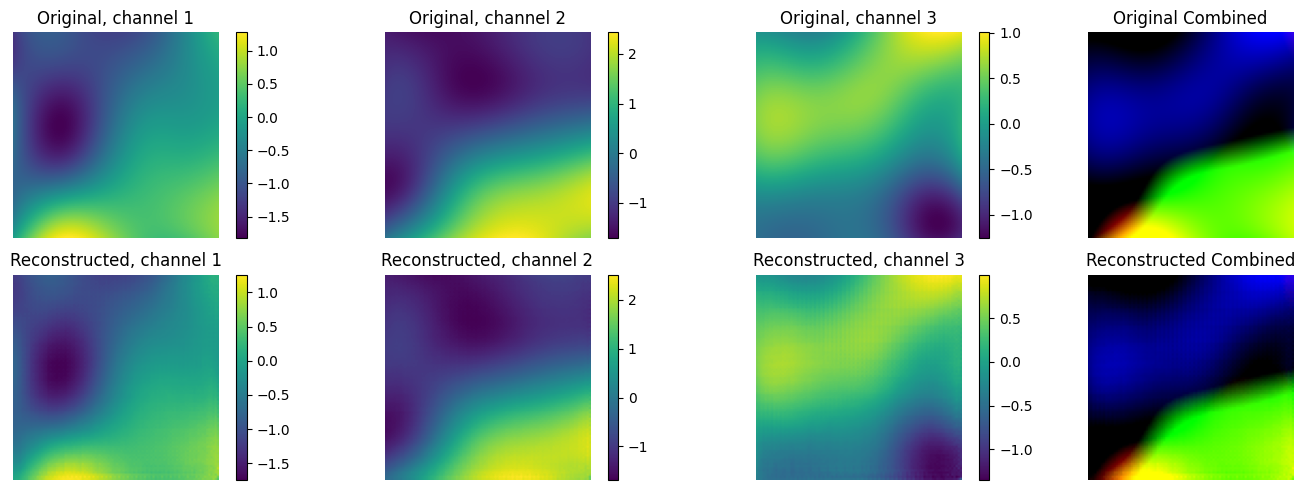

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


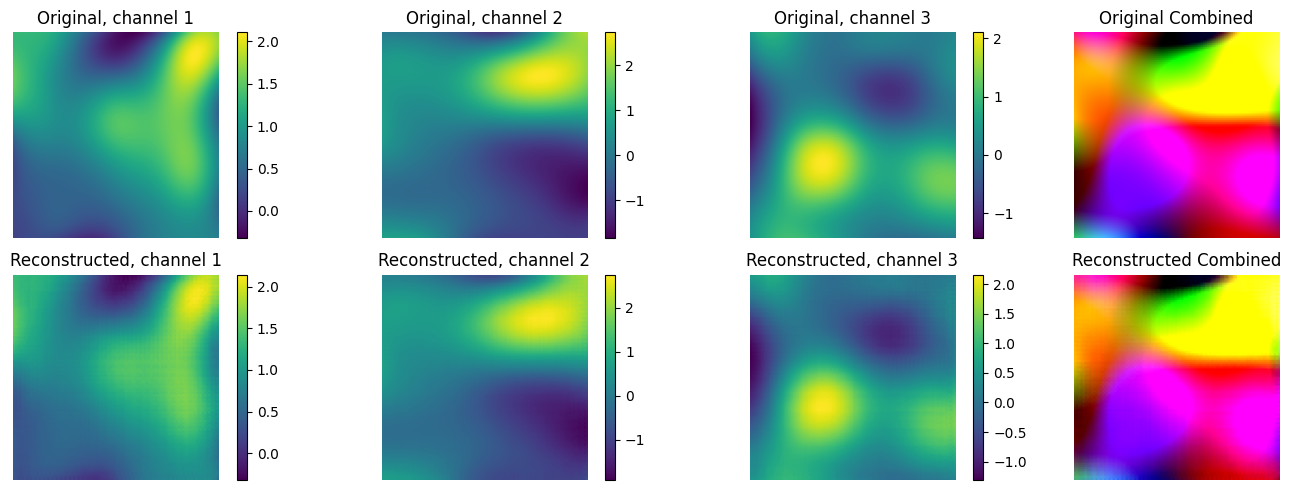

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


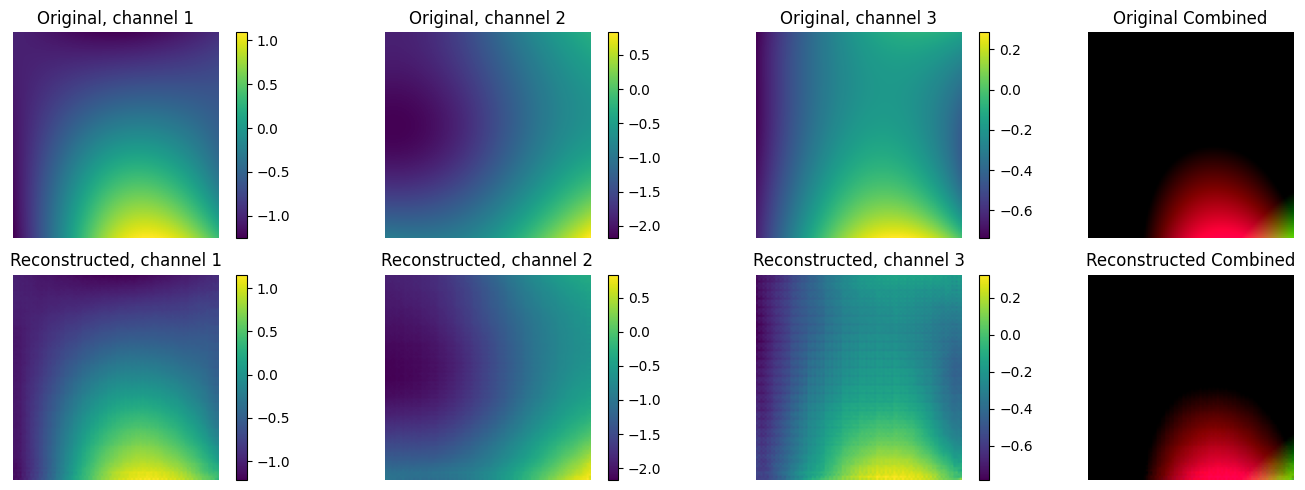

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


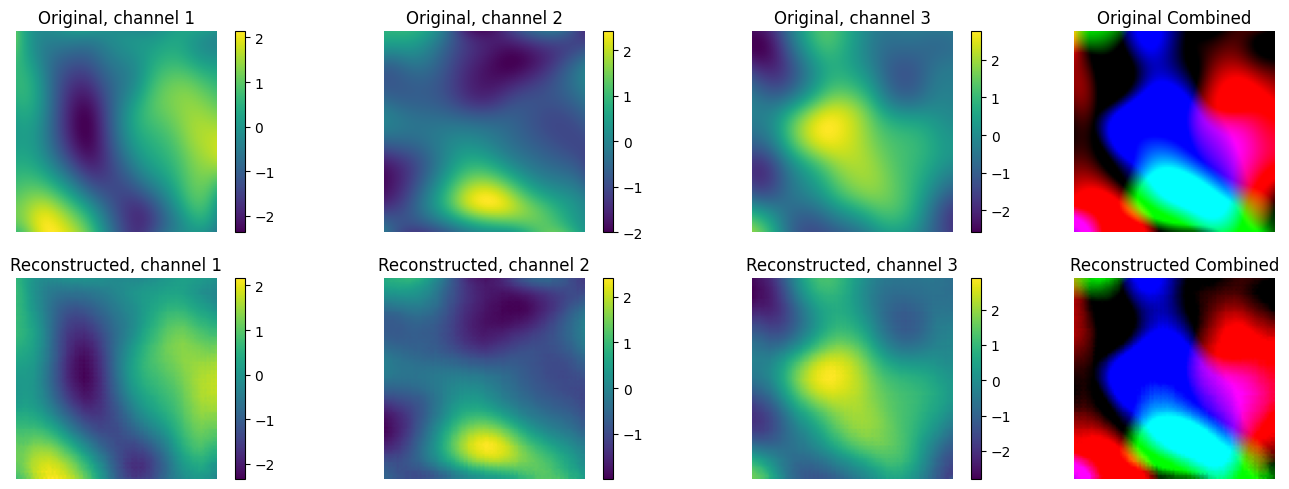

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


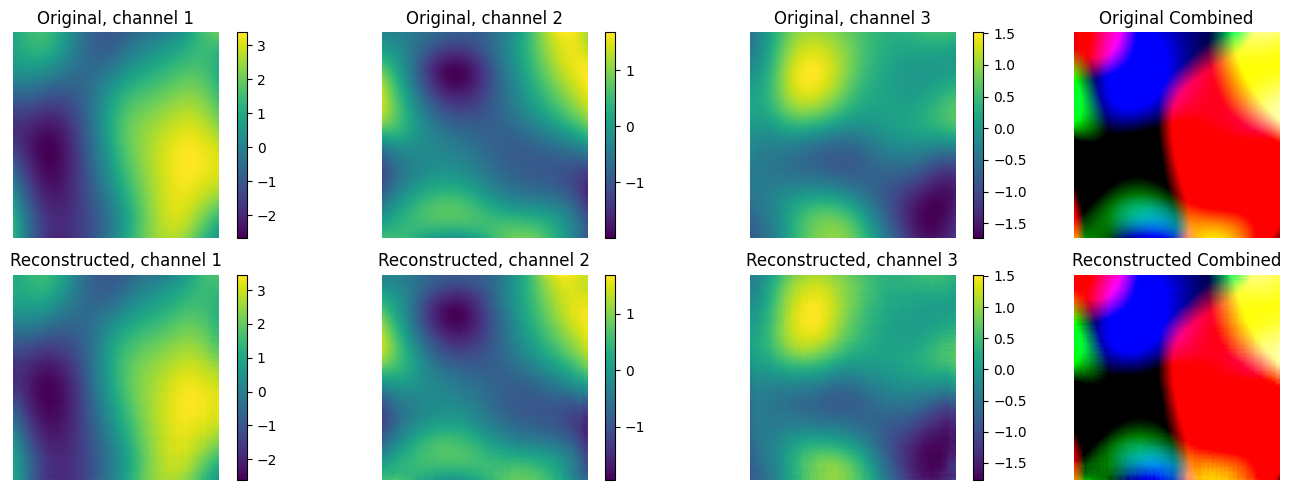

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

def plot_reconstructions9(model, data_loader, n_images=5, device="cpu"):
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            input_images = batch[:n_images].to(device)
            recon_images = model(input_images)
            break

    n_channels = 3

    for i in range(n_images):
        fig, axes = plt.subplots(2, n_channels + 1, figsize=(15, 5))

        for c in range(n_channels):
            # Original images
            img = input_images[i][c].cpu().numpy()
            im = axes[0, c].imshow(img, cmap='viridis')
            axes[0, c].set_title(f"Original, channel {c+1}")
            axes[0, c].axis("off")
            plt.colorbar(im, ax=axes[0, c], fraction=0.05, pad=0.05)

            # Reconstructed images
            recon_img = recon_images[i][c].cpu().numpy()
            im = axes[1, c].imshow(recon_img, cmap='viridis')
            axes[1, c].set_title(f"Reconstructed, channel {c+1}")
            axes[1, c].axis("off")
            plt.colorbar(im, ax=axes[1, c], fraction=0.05, pad=0.05)

        # Original images combined
        img_combined = input_images[i].cpu().numpy().transpose(1, 2, 0)
        axes[0, n_channels].imshow(img_combined)
        axes[0, n_channels].set_title("Original Combined")
        axes[0, n_channels].axis("off")

        # Reconstructed images combined
        recon_img_combined = recon_images[i].cpu().numpy().transpose(1, 2, 0)
        axes[1, n_channels].imshow(recon_img_combined)
        axes[1, n_channels].set_title("Reconstructed Combined")
        axes[1, n_channels].axis("off")

        plt.tight_layout()
        plt.show()

with torch.no_grad():
    plot_reconstructions9(model, test_loader, device="cuda")